# Assignment 1 - Conditioning and Sensitivity

Julia translation of MATLAB numerical analysis assignment.

In [1]:
# Install required packages if needed
using Pkg
Pkg.add(["Plots", "LinearAlgebra"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [2]:
using Plots
using LinearAlgebra
gr()  # Use GR backend for plotting

Plots.GRBackend()

## Examples and Demonstration

### Converting to Single Precision

Julia stores numbers by default in 64-bit double precision floating-point numbers. To demonstrate floating-point errors, we convert numbers to single-precision (`Float32`) and compare to double-precision results.

### Demonstrating Cancellation Error

Single precision difference: 0.099999994
Absolute error: 5.960464483090178e-9
Relative error: 5.960464483090178e-8


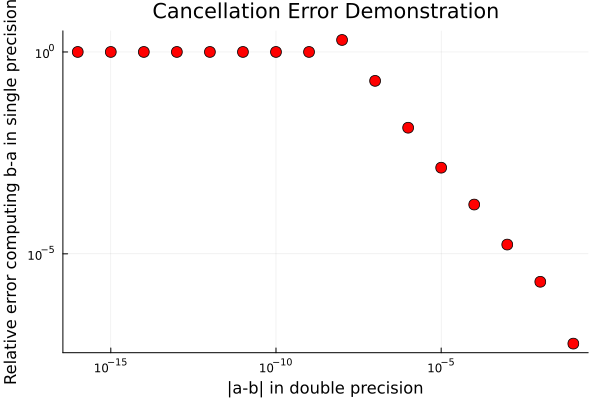

In [3]:
# Demonstrating cancellation error
a = rand()  # Random number in double precision
b = a + 0.1

diff_single = Float32(b) - Float32(a)
println("Single precision difference: ", diff_single)
println("Absolute error: ", abs(diff_single - 0.1))
println("Relative error: ", abs(diff_single - 0.1) / 0.1)

# Sweep over different differences
diffs = 10.0 .^ (-16:-1)
relerrs = zeros(length(diffs))

for i in 1:length(diffs)
    b = a + diffs[i]
    diff_single = Float32(b) - Float32(a)
    relerrs[i] = abs(diff_single - diffs[i]) / diffs[i]
end

plot(diffs, relerrs, 
     seriestype=:scatter, 
     xscale=:log10, yscale=:log10,
     markersize=6, color=:red,
     xlabel="|a-b| in double precision",
     ylabel="Relative error computing b-a in single precision",
     legend=false,
     title="Cancellation Error Demonstration")

## Problem 1

### Part (a) - Forward Error Analysis

**Central difference approximation:**

$$D_f = \frac{f(x+h) - f(x-h)}{2h} = f'(x)(1 + \delta_t)$$

where $\delta_t = O(h^2)$ (truncation error).

**Floating-point error analysis:**

The computed result satisfies:

$$\hat{D}_f - f'(x) = O(h^2) + O\left(\frac{\varepsilon_M}{h}\right)$$

**Absolute error bound:**

$$|\hat{D}_f - f'(x)| \leq C_1 h^2 + C_2 \frac{\varepsilon_M}{h}$$

**Optimal step size:**

Minimizing the error bound:

$$h_{\text{optimal}} \propto \varepsilon_M^{1/3}$$

For double precision: $h_{\text{opt}} \approx 6.06 \times 10^{-6}$

### Part (b) - Double Precision Central Difference

In [4]:
# Define function and its derivative
f(x) = exp(-x) - x * (2 - x)
x0 = 2.0

# Range of h values to investigate
h = 10.0 .^ range(-1, -20, length=50)

# Machine precision for double
epsval = eps(Float64)
println("Machine epsilon (Float64): ", epsval)

# Compute central difference approximation
centdiff = [(f(x0 + hh) - f(x0 - hh)) / (2 * hh) for hh in h]

# True derivative: f'(x) = -exp(-x) - 2 + 2x
# At x=2: f'(2) = -exp(-2) - 2 + 4 = 2 - exp(-2) ≈ 1.86466471676
D_true = 2 - exp(-2)
println("True derivative at x=2: ", D_true)

# Compute errors
abs_err = abs.(centdiff .- D_true)
rel_err = abs_err ./ abs(D_true)

# Theoretical error bound (with C₁=1, C₂=1)
error_bound = h.^2 .+ epsval ./ h

Machine epsilon (Float64): 2.220446049250313e-16
True derivative at x=2: 1.8646647167633872


50-element Vector{Float64}:
     0.010000000000002222
     0.001676832936816431
     0.00028117686981066496
     4.714866366691133e-5
     7.906043289877429e-6
     1.3257115584383729e-6
     2.2230011919832155e-7
     3.7277087277558246e-8
     6.253360468043115e-9
     1.054971744715238e-9
     ⋮
    17.554942412862193
    42.87010144395355
   104.69106389482151
   255.6611365559398
   624.3380696822591
  1524.6667151120942
  3723.317069794792
  9092.537972278202
 22204.46049250313

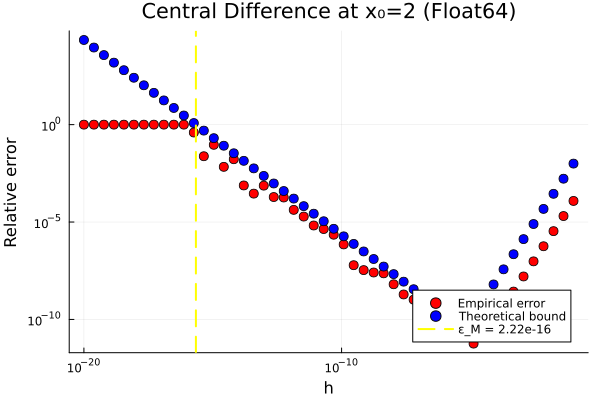

In [5]:
# Plot results
p1 = plot(h, rel_err, 
     seriestype=:scatter, 
     xscale=:log10, yscale=:log10,
     markersize=5, color=:red,
     label="Empirical error",
     xlabel="h",
     ylabel="Relative error",
     title="Central Difference at x₀=2 (Float64)",
     legend=:bottomright)

plot!(p1, h, error_bound, 
      seriestype=:scatter, 
      markersize=5, color=:blue,
      label="Theoretical bound")

# Add vertical line at machine epsilon
vline!([epsval], linestyle=:dash, color=:yellow, 
       label="ε_M = $(round(epsval, sigdigits=4))", linewidth=2)

display(p1)

**Observations:**

- The empirical error closely follows the theoretical bound
- Floating-point error dominates for small h (large $\varepsilon_M/h$)
- Truncation error dominates for large h (large $h^2$)
- Optimal h is around $10^{-5}$ to $10^{-6}$
- Below $h \approx 10^{-16}$, degeneracy occurs: $f(x_0+h) = f(x_0)$ in floating point

### Part (c) - Single Precision Central Difference

In [6]:
# Single precision (Float32) analysis
f32(x) = exp(-x) - x * (2 - x)  # Julia will use Float32 arithmetic if input is Float32

x0_32 = Float32(2.0)
h_32 = Float32.(10.0 .^ range(-1, -20, length=50))

# Machine precision for single
eps_single = eps(Float32)
println("Machine epsilon (Float32): ", eps_single)
println("Machine epsilon (Float64): ", eps(Float64))

# Compute central difference in single precision
centdiff_single = [(f32(x0_32 + hh) - f32(x0_32 - hh)) / (2 * hh) for hh in h_32]

# Convert to Float64 for error calculation
centdiff_f64 = Float64.(centdiff_single)
h_f64 = Float64.(h_32)

# Errors
abs_err_32 = abs.(centdiff_f64 .- D_true)
rel_err_32 = abs_err_32 ./ abs(D_true)

# Theoretical error bound for single precision
error_bound_32 = 0.01 .* h_f64.^2 .+ 1e9 .* (eps(Float64) ./ h_f64)

Machine epsilon (Float32): 1.1920929e-7
Machine epsilon (Float64): 2.220446049250313e-16


50-element Vector{Float64}:
 0.00010222044899639536
 2.2190776717258588e-5
 1.6053672767961234e-5
 3.28089181564833e-5
 7.904878428478166e-5
 0.00019286152528046911
 0.0004709479385996039
 0.0011500747613815184
 0.002808542844598956
 0.006858610210259626
 ⋮
 1.7554942754183285e10
 4.28701026199292e10
 1.0469106555012247e11
 2.5566112422463254e11
 6.243380597562213e11
 1.5246666571411255e12
 3.723317111568161e12
 9.092537682947863e12
 2.2204461197150105e13

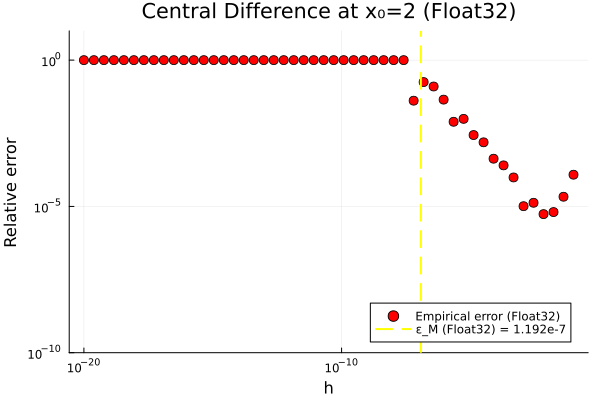

In [7]:
# Plot single precision results
p2 = plot(h_f64, rel_err_32, 
     seriestype=:scatter, 
     xscale=:log10, yscale=:log10,
     markersize=5, color=:red,
     label="Empirical error (Float32)",
     xlabel="h",
     ylabel="Relative error",
     title="Central Difference at x₀=2 (Float32)",
     legend=:bottomright,
     ylims=(1e-10, 10))

# Add vertical line at single precision epsilon
vline!([eps_single], linestyle=:dash, color=:yellow, 
       label="ε_M (Float32) = $(round(eps_single, sigdigits=4))", linewidth=2)

display(p2)

**Single vs Double Precision Comparison:**

| Property | Float32 | Float64 |
|----------|---------|--------|
| Machine epsilon | $\approx 10^{-7}$ | $\approx 10^{-16}$ |
| Minimum achievable error | $\approx 10^{-5}$ | $\approx 10^{-11}$ |
| Optimal h | $\approx 5 \times 10^{-3}$ | $\approx 6 \times 10^{-6}$ |
| Degeneracy threshold | $\approx 10^{-7}$ | $\approx 10^{-16}$ |

## Problem 2 - Condition Number Analysis

### Part (a)

The matrix B formed from normalized basis vectors:

$$B = \begin{bmatrix} \frac{1}{\sqrt{2}} & \frac{1+\gamma}{\sqrt{2+2\gamma+\gamma^2}} \\ \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2+2\gamma+\gamma^2}} \end{bmatrix}$$

As $\gamma \to 0$, the condition number grows like $\kappa_\infty(B) \sim \frac{C}{|\gamma|}$

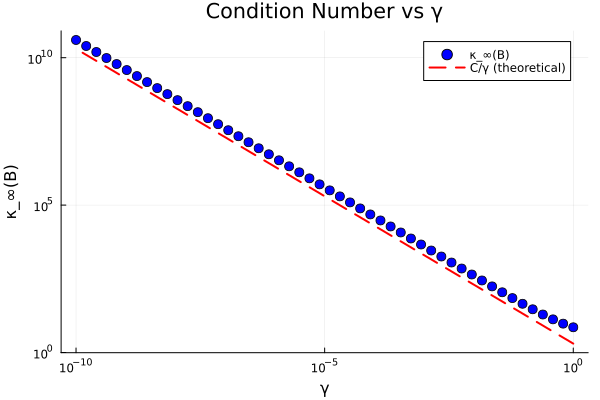

In [8]:
# Condition number analysis for nearly-dependent basis
function basis_matrix(γ)
    norm1 = sqrt(2)
    norm2 = sqrt(2 + 2γ + γ^2)
    B = [1/norm1  (1+γ)/norm2;
         1/norm1  1/norm2]
    return B
end

# Test for various γ values
γ_values = 10.0 .^ range(0, -10, length=50)
cond_inf = [cond(basis_matrix(γ), Inf) for γ in γ_values]

# Plot condition number vs γ
p3 = plot(γ_values, cond_inf,
     xscale=:log10, yscale=:log10,
     seriestype=:scatter,
     markersize=5, color=:blue,
     xlabel="γ",
     ylabel="κ_∞(B)",
     title="Condition Number vs γ",
     label="κ_∞(B)")

# Add theoretical 1/γ line
plot!(p3, γ_values, 2 ./ γ_values, 
      linestyle=:dash, color=:red, 
      label="C/γ (theoretical)", linewidth=2)

display(p3)

In [9]:
# Demonstrate ill-conditioning with a specific example
γ_test = 1e-8
B = basis_matrix(γ_test)

println("For γ = ", γ_test)
println("Matrix B:")
display(B)
println("\nDeterminant: ", det(B))
println("Condition number (∞-norm): ", cond(B, Inf))
println("Condition number (2-norm): ", cond(B, 2))

2×2 Matrix{Float64}:
 0.707107  0.707107
 0.707107  0.707107

For γ = 1.0e-8
Matrix B:

Determinant: -4.999999943063915e-9
Condition number (∞-norm): 4.000000055548868e8
Condition number (2-norm): 4.000000035769182e8


## Summary

This assignment demonstrates key concepts in numerical analysis:

1. **Floating-point arithmetic** introduces rounding errors that grow as $O(\varepsilon_M/h)$ for finite difference approximations

2. **Truncation error** decreases as $O(h^2)$ for central differences

3. **Optimal step size** balances these competing effects: $h_{opt} \propto \varepsilon_M^{1/3}$

4. **Condition number** measures sensitivity to perturbations; ill-conditioned problems have large condition numbers